In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import shutil
from os.path import join

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path :
    sys.path.append(module_path)

    
import _ressources.chain as chain
import _ressources.tools as tools
import _ressources.lumenclass as lc
import _ressources.gen_config as gc


from scipy.optimize import curve_fit

main_dir = '/Users/mathieuleverge/git/chain_lumen/_data/critical_chiv/'



In [2]:
def logscale(decades, points, scale=10) :
    Lscale = []
    for d in decades :
        for p in points :
            Lscale += [p*scale**d]
    return Lscale

def read_eventfile(eventfile) :
    s = open(eventfile, 'r').readlines()
    if '(C)' in s[-1].split() :
        return ('C', int(s[-1].split()[-1]))
    elif '(D)' in s[-1].split() :
        return ('D', int(s[-1].split()[-1]))
    elif '(M)' in s[-1].split() :
        return ('M', int(s[-1].split()[-1]))
    
def read_configfile(config_folder, param) :

    lumens = np.loadtxt(join(config_folder, 'lumens.dat'))
    bridges = np.loadtxt(join(config_folder, 'bridges.dat'))

    if param == 'ca' :
        return lumens[1:-1, -1], bridges[1:-1, -1]
    elif param == 'length' :
        return lumens[1:-1, 2], bridges[1:-1, 3]
    elif param == 'nb_ions' :
        return lumens[1:-1, 3]
    return None

def give_outputs(chi_list, folder, param) :
    out_chi = {}
    for chi in chi_list :
        out_chi[chi] = {}
        L = os.listdir(join(folder, 'chiv' + str(chi)))
        for elem in L :
            #if elem.startswith('run') :
            if elem.startswith('run') :
                eventfile = join(folder, 'chiv' + str(chi), elem, 'events.txt')
                config_folder = join(folder, 'chiv' + str(chi), elem, 'config')
                try :
                    out_chi[chi][elem] = [read_configfile(config_folder, param), read_eventfile(eventfile)]
                except :
                    print(chi, elem)
    return out_chi

def plot_diagram(out, param_pos) :
    color_dict = {'M' : ['purple', 's'], 
                  'C' : {1 : ['blue', '*'], 2 : ['red', 'o']}, 
                  'D' : ['green', '^']}
    for chi in out.keys() :
        print(str(chi) + '      ', end='\r')
        for sim in out[chi].keys() :
            y = out[chi][sim][0][param_pos[0]][param_pos[1]]
            try :
                fate, winner = out[chi][sim][1]
            except :
                print(chi, sim, out[chi][sim][1])     
                fate = None
            
            if fate == 'C' :
                color, symbol = color_dict[fate][winner]
            elif fate != None :
                color, symbol = color_dict[fate]
            
            if out[chi][sim][1] != None and fate != None :
                plt.scatter(float(chi), y, color = color, marker=symbol)
            else :
                plt.scatter(float(chi), y, color = 'k', marker='*')

    
def edit_configtpl(main_dir, subdir, subsubdir, chiv,  chis) :
    f = open(join(main_dir, subdir, subsubdir, 'config.conf'), 'r')
    L = f.readlines()
    f.close()
    #print(L[1])
    #print(os.path.join(main_dir,subdir,subsubdir))
    L[10] = 'outdir = '+join(main_dir,subdir,subsubdir) + '\n'
    L[39] = L[39].replace('chis = 50.', 'chis = ' + chis)
    L[40] = L[40].replace('chiv = 50.', 'chiv = ' + chiv)
    s = ''
    for i in range(len(L)) :
        s += str(L[i])
    f = open(join(main_dir, subdir, subsubdir, 'config.conf'), 'w')
    f.write(s)
    f.close()
    
    

(0.1, 2.2)

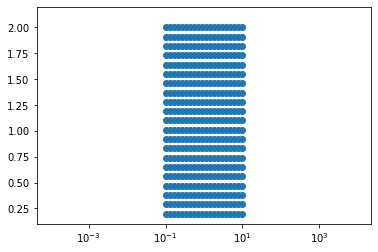

In [96]:
xmin, xmax = 0.1, 10.
ymin, ymax = 0.2, 2
x = np.logspace(np.log10(xmin), np.log10(xmax), 20)
#y = np.logspace(ymin, ymax, 25)
y = np.linspace(0.2, 2., 21)
xscatter, yscatter = np.meshgrid(x, y)

plt.xscale('log')
plt.scatter(xscatter, yscatter)

plt.ylim(ymin*.5, ymax*1.1)


In [77]:
new_dict = 0
clean_dir = 1

if new_dict :
    if clean_dir : 
        for elem in os.listdir(main_dir) :
            if elem.startswith('chis') : 
                shutil.rmtree(join(main_dir, elem))
    
    for i in range(len(x)) :
        chis = "{:.3e}".format(x[i])
        subdir = 'chis'+chis
        

        # Make directories
        try : 
            os.mkdir(join(main_dir, subdir))
            shutil.copy2(join(main_dir, 'config.conf.tpl'), join(main_dir, subdir, 'config.conf.tpl'))
        except : pass
        #shutil.copytree(join(main_dir, 'config'), join(main_dir, subdir, subsubdir, 'config'))

        for j in range(len(y)) :
            chiv = "{:.3e}".format(y[j])
            subsubdir = 'chiv'+chiv
            
            #if 1 :
            try : 
                os.mkdir(join(main_dir, subdir, subsubdir))
                shutil.copy2(join(main_dir, subdir, 'config.conf.tpl'), join(main_dir, subdir, subsubdir, 'config.conf'))
            #else :  1
            except : pass
            
            # Edit config.conf.tpl
            edit_configtpl(main_dir, subdir, subsubdir, chiv, chis)
            

        

        # Gen configurations
        #os.chdir(join(main_dir, subdir, subsubdir))
        #arg1 = 'params=paramsfile.txt'
        #gc.main(join(main_dir, subdir, subsubdir, 'config.conf.tpl'), args=['params=paramsfile.txt'])
        #os.chdir(cwd)

    s = 'chis = '
    for i in range(len(x)) :
        s += "{:.3e}".format(x[i]) +','
    print(s)
    
    r = 'chiv = '
    for j in range(len(y)) :
        r += "{:.3e}".format(y[j]) +','
    print(r)
    

chis = 1.000e-01,1.274e-01,1.624e-01,2.069e-01,2.637e-01,3.360e-01,4.281e-01,5.456e-01,6.952e-01,8.859e-01,1.129e+00,1.438e+00,1.833e+00,2.336e+00,2.976e+00,3.793e+00,4.833e+00,6.158e+00,7.848e+00,1.000e+01,
chiv = 2.000e-01,2.900e-01,3.800e-01,4.700e-01,5.600e-01,6.500e-01,7.400e-01,8.300e-01,9.200e-01,1.010e+00,1.100e+00,1.190e+00,1.280e+00,1.370e+00,1.460e+00,1.550e+00,1.640e+00,1.730e+00,1.820e+00,1.910e+00,2.000e+00,


In [79]:
def read_eventfile(eventfile) :
    s = open(eventfile, 'r').readlines()
    if '(C)' in s[-1].split() :
        return ('C', int(s[-1].split()[-1]))
    elif '(D)' in s[-1].split() :
        return ('D', int(s[-1].split()[-1]))
    elif '(M)' in s[-1].split() :
        return ('M', int(s[-1].split()[-1]))
    
def read_configfile(config_folder, param) :

    lumens = np.loadtxt(join(config_folder, 'lumens.dat'))
    bridges = np.loadtxt(join(config_folder, 'bridges.dat'))

    if param == 'ca' :
        return lumens[1:-1, -1], bridges[1:-1, -1]
    elif param == 'length' :
        return lumens[1:-1, 2], bridges[1:-1, 3]
    elif param == 'nb_ions' :
        return lumens[1:-1, 3]
    return None

def give_outputs(chis_list, chiv_list, folder) :
    out = {}
    for chis in chis_list :
        out[chis] = {}
        for chiv in chiv_list :
            eventfile = join(folder, 'chis' + str(chis), 'chiv' + str(chiv), 'events.txt')
            try :
            #if 1 :
                res = read_eventfile(eventfile)
                #print(res)
                out[chis][chiv] = res
            #else : 1
            except : pass
    return out

In [80]:
def plot_diagram(out) :

    color_dict = {'M' : ['purple', 's'], 
                  'C' : {1 : ['blue', '*'], 2 : ['red', 'o']}, 
                  'D' : ['green', '^']}
    for chis in out.keys() :
        print(str(chis) + '      ', end='\r')
        for chiv in out[chis].keys() :
            
            try :
                fate, winner = out[chis][chiv]
                #print(fate, winner)
            except :
                print(chis, chiv)     
                fate = None
            
            if fate == 'C' :
                color, symbol = color_dict[fate][winner]
            elif fate != None :
                color, symbol = color_dict[fate]
            
            if out[chis][chiv] != None and fate != None :
                plt.scatter(float(chis), float(chiv), color = color, marker=symbol)
            else :
                plt.scatter(float(chis), float(chiv), color = 'k', marker='*')

In [81]:
v2 = 0

In [82]:
if v2 : 
    chis_list = [elem[4:] for elem in os.listdir(join(main_dir, 'v2')) if elem.startswith('chis')]
    chiv_list = [elem[4:] for elem in os.listdir(join(main_dir, 'v2','chis'+chis_list[0])) if elem.startswith('chiv')]
else :
    chis_list = [elem[4:] for elem in os.listdir(join(main_dir)) if elem.startswith('chis')]
    chiv_list = [elem[4:] for elem in os.listdir(join(main_dir,'chis'+chis_list[0])) if elem.startswith('chiv')]




In [228]:
#chis_list = ["{:.3e}".format(x[i]) for i in range(len(x))]
#chiv_list = ["{:.3e}".format(y[j]) for j in range(len(y))]

if v2 : out = give_outputs(chis_list, chiv_list, os.path.join(main_dir, 'v2'))
else : out = give_outputs(chis_list, chiv_list, os.path.join(main_dir))

xmin, xmax = np.log10(np.min(np.array(chis_list, dtype=float))), np.log10(np.max(np.array(chis_list, dtype=float)))
ymin, ymax = np.log10(np.min(np.array(chiv_list, dtype=float))), np.log10(np.max(np.array(chiv_list, dtype=float)))


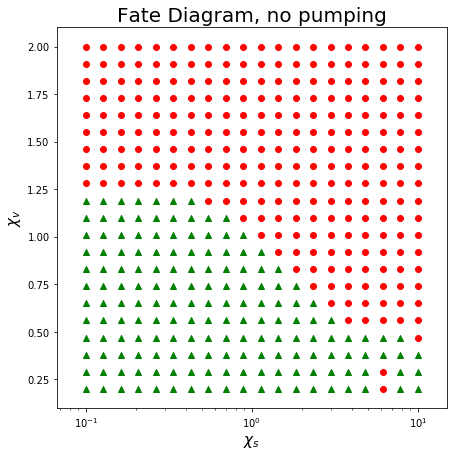

In [229]:
plt.figure(figsize=(7, 7))
plt.xscale('log')
#plt.yscale('log')

frac = 1.5
plt.xlim((1./frac)*10.**(xmin), frac*10.**(xmax))
plt.ylim(0.1, 2.1)
#plt.ylim()

plot_diagram(out)

plt.xlabel('$\chi_s$', fontsize=15)
plt.ylabel('$\chi_v$', fontsize=15)

plt.title('Fate Diagram, no pumping', fontsize=20)
#plt.savefig(join('/Users/mathieuleverge/Documents/cavidoc/hydroosmotic/','critical_chiv_vs_chis.eps'), format='eps')
plt.show()

Import config from /Users/mathieuleverge/git/chain_lumen/_data/critical_chiv/config/
Import successful !


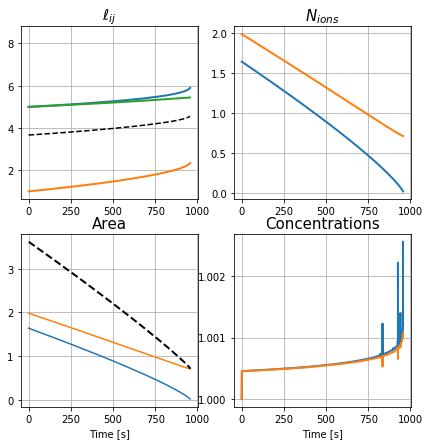

0.0






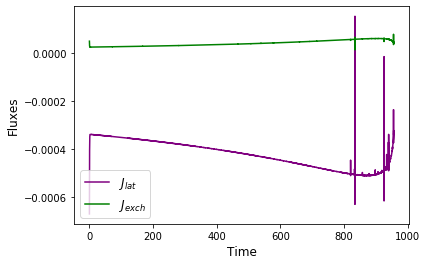

In [223]:
subdir = 'chis6.158e+00'
subsubdir = 'chiv2.000e-01'
conf, ch = chain.load_config(os.path.join(main_dir, subdir, subsubdir, 'config.conf'))
#print(ch)
x_ch = np.linspace(0., ch.total_length, 1001)
#tools.plot_profile(x, ch)

ell = tools.load_brfile(os.path.join(main_dir, subdir, subsubdir, 'sim_bridges.dat'))

x_log = 0
total_area = 1

if ch.lumen_type == 'hydroosmotic' :
    L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, subsubdir, 'sim_all.dat'), hydroosmotic=True)
    tools.plot_evolution(L, nions, ell, x_logscale=x_log, savename=join(main_dir, 'case2.eps'), savefig=False, nbins=5, show_totalarea=total_area)

print(ch.lumens_dict[1].ca)
#print(read_eventfile(os.path.join(main_dir, subdir, subsubdir, 'events.txt')))
print('\n\n\n')

fluxes = np.loadtxt(os.path.join(main_dir, subdir, subsubdir, 'fluxes.dat'), skiprows=1)
end = 10
#plt.xscale('log')
#plt.yscale('log')
plt.plot(fluxes[:-end, 0], fluxes[:-end, 1], label = r'$J_{lat}$', color = 'purple')
plt.plot(fluxes[:-end, 0], fluxes[:-end, 2], label = r'$J_{exch}$', color='green')

plt.legend(loc=3, fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Fluxes', fontsize=12)
plt.show()



Import config from /Users/mathieuleverge/git/chain_lumen/_data/critical_chiv/config/
======= CHAIN =======
Type         : hydroosmotic
Total length : 15.2
Current Time : 0
Screening lengths : 
        xi_s = 0.09999999999999996
        xi_v = 0.09999999999999996
Permeation times :
       tau_s = 1.0
       tau_v = 1.0
Pumping : None
======= LUMENS =======
Nb lumens : 2
Lumen 0 is at position 0.00000 with length 0.00000 and 0.00000 ions with pumping 0.00000
Lumen 1 is at position 6.00000 with length 1.00000 and 1.63783 ions with pumping 0.00000
Lumen 2 is at position 9.10000 with length 1.10000 and 1.98177 ions with pumping 0.00000
Lumen -1 is at position 15.20000 with length 0.00000 and 0.00000 ions with pumping 0.00000
======= BRIDGES ======
Bridge 0 : (0, 1) has length 5.00000 with pumping 0.00000
Bridge 1 : (1, 2) has length 1.00000 with pumping 0.00000
Bridge 2 : (2, -1) has length 5.00000 with pumping 0.00000

Import successful !


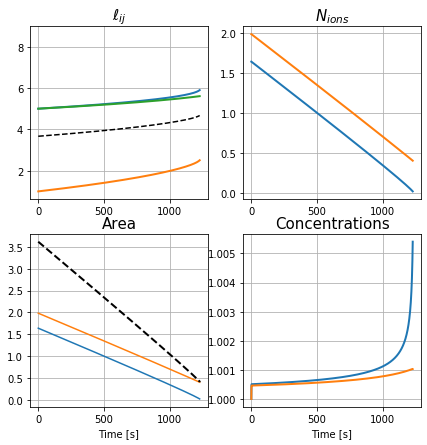

In [7]:
subdir = 'chis1.000e-01/chiv1.000e-01'
conf, ch = chain.load_config(os.path.join(main_dir, subdir, 'config.conf'))
print(ch)
x_ch = np.linspace(0., ch.total_length, 1001)
#tools.plot_profile(x, ch)

ell = tools.load_brfile(os.path.join(main_dir, subdir, 'sim_bridges.dat'))

x_log = 0
total_area = 1

if ch.lumen_type == 'hydroosmotic' :
    L, nions, pos = tools.load_file(os.path.join(main_dir, subdir, 'sim_all.dat'), hydroosmotic=True)
    tools.plot_evolution(L, nions, ell, x_logscale=x_log, show_totalarea=total_area)




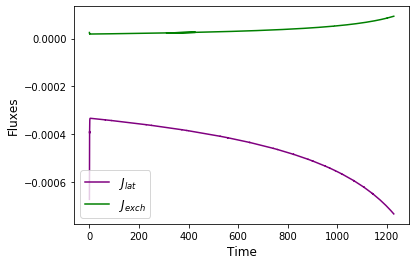

In [8]:
fluxes = np.loadtxt(os.path.join(main_dir, subdir, 'fluxes.dat'), skiprows=1)
end = 10


#plt.xscale('log')
#plt.yscale('log')
plt.plot(fluxes[:-end, 0], fluxes[:-end, 1], label = r'$J_{lat}$', color = 'purple')
plt.plot(fluxes[:-end, 0], fluxes[:-end, 2], label = r'$J_{exch}$', color='green')

plt.legend(loc=3, fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Fluxes', fontsize=12)
plt.show()
